# Lab 5/6

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

## Setup for SUSY Dataset

In [4]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))

In [5]:
filename="SUSY-Small.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [6]:
df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

## FPR/TPR/ROC/AUC

In previous lecture, we wrote a helper function to compute FPR and TPR as function of selection. We are considering 4 different selections:
1. $x > x_c$
2. $x < x_c$
3. $|x - x_0| > x_c$
4. $|x - x_0| < x_c$

We so far have only implemented 1 in lecture:


In [7]:
def compute_rate(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_

Let's remind ourselves how to use/plot this function:

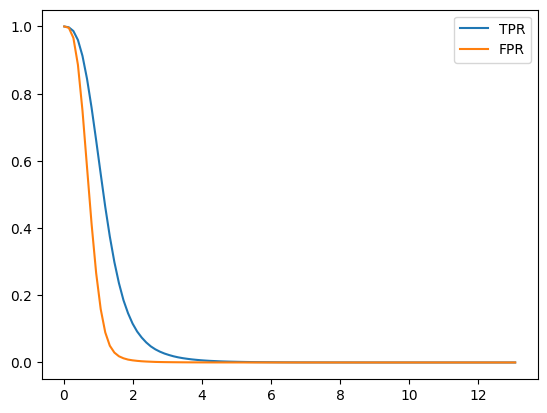

In [8]:
TPR,bins=compute_rate(df_sig["M_TR_2"])
FPR,bins=compute_rate(df_bkg["M_TR_2"],bins=bins)

plt.plot(bins[:-1],TPR,label="TPR")
plt.plot(bins[:-1],FPR,label="FPR")
plt.legend()


### ROC
Creating a ROC curve is as simple as ploting FPR vs TPR. We'll add a line from (0,0) to (1,1) to represent a bad ROC curve. 

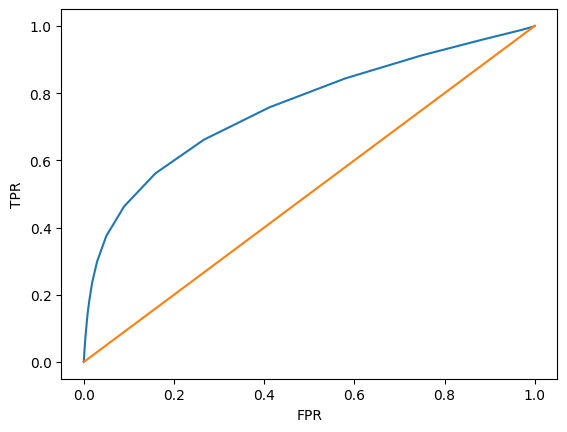

In [10]:
plt.plot(FPR,TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0,1],[0,1])


In [11]:
TPR

array([1.00000000e+00, 9.97483042e-01, 9.86507885e-01, 9.59815917e-01,
       9.12412484e-01, 8.43918079e-01, 7.57909660e-01, 6.61279417e-01,
       5.61198718e-01, 4.63033000e-01, 3.74939475e-01, 2.98963990e-01,
       2.36262514e-01, 1.85356278e-01, 1.46637877e-01, 1.15732077e-01,
       9.21546817e-02, 7.41782809e-02, 5.95781805e-02, 4.79312526e-02,
       3.90891841e-02, 3.21751838e-02, 2.65959999e-02, 2.21858710e-02,
       1.83602696e-02, 1.53329407e-02, 1.28901394e-02, 1.09228118e-02,
       9.21285088e-03, 7.83877511e-03, 6.62173657e-03, 5.63589173e-03,
       4.79399769e-03, 4.17021091e-03, 3.49844053e-03, 3.00551811e-03,
       2.60420075e-03, 2.28140199e-03, 1.97605182e-03, 1.69687452e-03,
       1.45259439e-03, 1.26502214e-03, 1.10798491e-03, 9.90206984e-04,
       8.81153351e-04, 7.93910445e-04, 6.97943248e-04, 5.97613907e-04,
       5.06008855e-04, 4.40576676e-04, 3.92593077e-04, 3.40247334e-04,
       2.87901590e-04, 2.61728718e-04, 2.44280137e-04, 2.22469410e-04,
      

Note that while the curve looks smooth, it's really not:

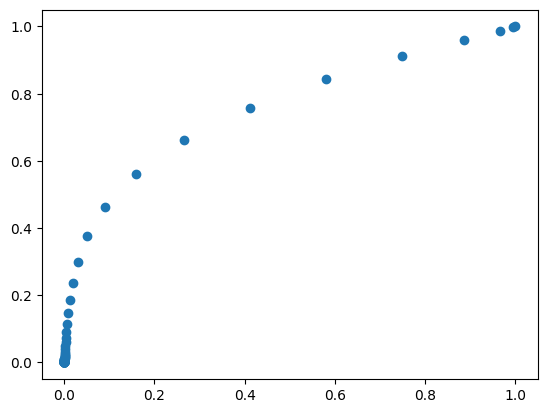

In [17]:
plt.scatter(FPR,TPR)

And it's drawn from top right to bottom left:

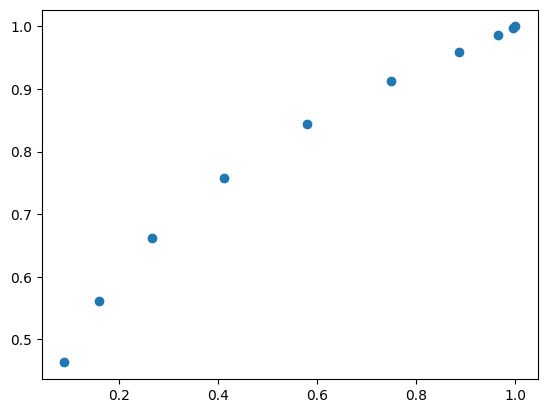

In [18]:
plt.scatter(FPR[:10],TPR[:10])

### AUC

The Area Under the Curve (AUC) is a reasonable assessment of how good a variable is in separating the two classes (signal/background). We can compute it using rectangles:

In [12]:
AUC = 0.
for k in range(len(FPR)-1):
    AUC+= (FPR[k] - FPR[k + 1]) * TPR[k]
AUC

0.7929065273629664

But the rectangles aren't very precise. In this case, do they under or over estimate the area?

Fairly easy to use trapezoids instead. The equation is:

$$
\int_a^b f(x) dx = \sum^N_{k=1} \frac{f(x_{k-1}) + f(x_k)}{2} \Delta x_k
$$

In [13]:
AUC = 0.
for k in range(len(FPR)-1):
    AUC += (FPR[k] - FPR[k + 1]) * (TPR[k]+TPR[k+1])/2.
AUC

0.7564120684107755

Instead of looping, we can tensor operations with `numpy`. First we need to know the size of the vector: 

In [14]:
FPR.shape

(100,)

We can compute the difference easily:

In [22]:
FPR[0:99]-FPR[1:100]

array([3.88547453e-03, 2.99314502e-02, 8.04389257e-02, 1.36239067e-01,
       1.69332082e-01, 1.68238831e-01, 1.45723762e-01, 1.07426723e-01,
       6.93143541e-02, 3.95786550e-02, 2.04430623e-02, 1.09657546e-02,
       6.00918922e-03, 3.86331403e-03, 2.24190403e-03, 1.57339558e-03,
       1.17819998e-03, 8.05164874e-04, 5.76173029e-04, 5.79866446e-04,
       3.10247016e-04, 2.54845763e-04, 1.66203758e-04, 1.51430091e-04,
       1.29269590e-04, 1.25576173e-04, 8.12551708e-05, 8.12551708e-05,
       4.80144191e-05, 6.27880865e-05, 3.32407517e-05, 4.43210022e-05,
       1.10802506e-05, 1.47736674e-05, 1.47736674e-05, 1.47736674e-05,
       3.69341685e-06, 1.84670843e-05, 2.21605011e-05, 2.58539180e-05,
       3.69341685e-06, 3.69341685e-06, 7.38683371e-06, 3.69341685e-06,
       0.00000000e+00, 3.69341685e-06, 3.69341685e-06, 0.00000000e+00,
       3.69341685e-06, 7.38683371e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Finally the AUC:

In [16]:
np.sum((FPR[0:99]-FPR[1:100]) * (TPR[0:99]+TPR[1:100])/2)

0.7564120684107758

Now lets wrap it up in a function:

In [17]:
def AUC(TPR,FPR):
    n = FPR.shape[0]
    return np.sum((FPR[0:n-1]-FPR[1:]) * (TPR[0:n-1]+TPR[1:])/2)

In [18]:
AUC(TPR,FPR)

0.7564120684107758

## Other Selections

Note that this function only works for the first possible selection criteria:

1. $x > x_c$
2. $x < x_c$
3. $|x - x_0| > x_c$
4. $|x - x_0| < x_c$

The second selection is easy:

In [19]:
def compute_rate_1(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_

def compute_rate_2(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist) * (bins_[1]-bins_[0])
    return R,bins_

Let's workout how to do the other ones:

(array([ 5318., 12729., 23025., 33336., 40063., 40225., 33394., 22779.,
        12996.,  5380.]),
 array([-2.10270858e+00, -1.68229992e+00, -1.26189127e+00, -8.41482615e-01,
        -4.21073961e-01, -6.65307045e-04,  4.19743347e-01,  8.40152001e-01,
         1.26056066e+00,  1.68096931e+00,  2.10137796e+00]),
 <BarContainer object of 10 artists>)

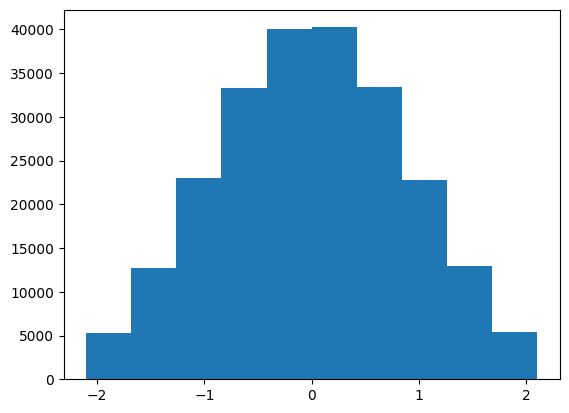

In [20]:
plt.hist(df_sig["l_1_eta"])

(array([33002., 33834., 33985., 31550., 29496., 25008., 18957., 12645.,
         7225.,  3543.]),
 array([2.33411789e-05, 3.20291865e-01, 6.40560389e-01, 9.60828912e-01,
        1.28109744e+00, 1.60136596e+00, 1.92163448e+00, 2.24190301e+00,
        2.56217153e+00, 2.88244005e+00, 3.20270858e+00]),
 <BarContainer object of 10 artists>)

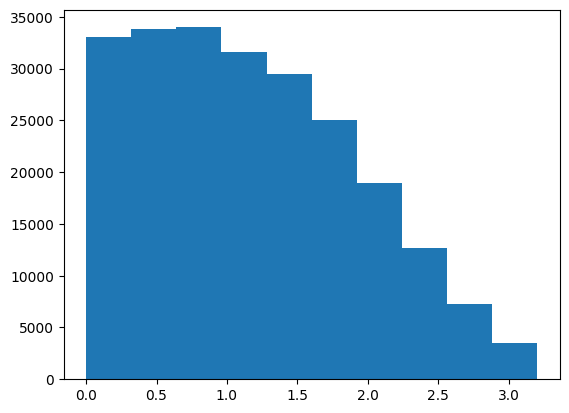

In [21]:
plt.hist(np.abs(df_sig["l_1_eta"]-1.1))

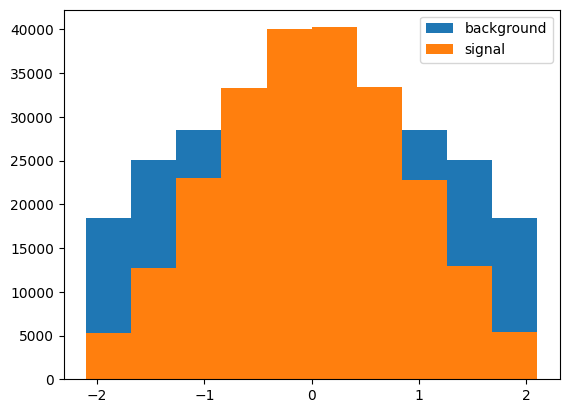

In [22]:
plt.hist(df_bkg["l_1_eta"],label="background")
plt.hist(df_sig["l_1_eta"],label="signal")
plt.legend()

## Linear Discriminant

From lab:

Compute the between-class $\bf{S}_B$ and within-class $\bf{S}_W$ covariance matrices defined as:

$$
\bf{S}_B = (\bf{m_2}-\bf{m_1})(\bf{m_2}-\bf{m_1})^T \\
$$
$$
\bf{S}_W = \sum_{i=1,2} \sum_{n=1}^{l_i} (\bf{x}_n^i - \bf{m}_i) (\bf{x}_n^i - \bf{m}_i)^T
$$

where $\bf{m_i}$ are the vectors containing the means for category 1 and 2, here defined as signal and background. Here $\bf{x}_n^i$ is the vector containing the observables for the $n$th example event in category $i$.

Compute the linear coefficients $\bf{w} = \bf{S_W}^{-1}(\bf{m_2}-\bf{m_1})$. Compare the histogram of the distribution of $F_n^i=\bf{w}^T\bf{x}_n^i$ for the two categories.



In [24]:
# Wrong
np.mean(np.array(df_sig))

0.7608215728656077

In [25]:
df_sig.shape

(229245, 19)

In [26]:
df_sig

,signal,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
8,1.0,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499988,1.0,0.939203,0.496058,0.492828,0.666188,-1.330323,-1.665897,1.501900,0.031668,1.689827,0.799185,1.104025,1.026356,0.824965,1.495351,1.117306,1.287094,1.173716,0.095378
499991,1.0,1.521302,0.734693,0.280339,1.590609,0.366158,-1.507171,0.828265,-0.980382,1.005345,-0.325469,1.318534,1.237360,0.832760,0.671833,1.340157,0.739515,1.115782,0.227649
499994,1.0,0.955334,-1.524135,-1.189764,1.470348,-0.296168,0.696495,0.851731,0.815524,0.259266,0.340013,1.219641,0.991118,0.721126,0.000000,1.242410,0.526798,1.313807,0.160337
499996,1.0,0.910016,-0.364544,-0.777120,0.543648,-0.910632,-1.723707,2.864673,1.458272,2.176558,-0.590911,0.673695,1.662140,2.189362,1.195041,0.910815,1.181893,1.252362,0.826035


We don't want the ground truth... that would be cheating:

In [27]:
df_sig_0 = df_sig.drop("signal",axis=1)
df_bkg_0 = df_bkg.drop("signal",axis=1)

df_sig_0

,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
8,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499988,0.939203,0.496058,0.492828,0.666188,-1.330323,-1.665897,1.501900,0.031668,1.689827,0.799185,1.104025,1.026356,0.824965,1.495351,1.117306,1.287094,1.173716,0.095378
499991,1.521302,0.734693,0.280339,1.590609,0.366158,-1.507171,0.828265,-0.980382,1.005345,-0.325469,1.318534,1.237360,0.832760,0.671833,1.340157,0.739515,1.115782,0.227649
499994,0.955334,-1.524135,-1.189764,1.470348,-0.296168,0.696495,0.851731,0.815524,0.259266,0.340013,1.219641,0.991118,0.721126,0.000000,1.242410,0.526798,1.313807,0.160337
499996,0.910016,-0.364544,-0.777120,0.543648,-0.910632,-1.723707,2.864673,1.458272,2.176558,-0.590911,0.673695,1.662140,2.189362,1.195041,0.910815,1.181893,1.252362,0.826035


Lets compute the mean of each feature over the signal population:

In [28]:
m_s= np.mean(df_sig_0,axis=0)
m_s

l_1_pT          1.291078
l_1_eta         0.000824
l_1_phi        -0.001524
l_2_pT          1.138668
l_2_eta         0.002487
l_2_phi         0.000049
MET             1.418381
MET_phi        -0.000470
MET_rel         1.275169
axial_MET       0.089314
M_R             1.183651
M_TR_2          1.268858
R               1.056352
MT2             1.074694
S_R             1.175023
M_Delta_R       1.186022
dPhi_r_b        1.014617
cos_theta_r1    0.282417
dtype: float64

Now lets compute $\Delta=(\bf{m_2}-\bf{m_1})$, we'll call it `delta`:

In [29]:
m_s= np.mean(df_sig_0,axis=0)
m_b= np.mean(df_bkg_0,axis=0)

delta = m_s-m_b
delta

l_1_pT          0.536629
l_1_eta         0.000855
l_1_phi         0.000871
l_2_pT          0.257438
l_2_eta         0.002871
l_2_phi         0.000682
MET             0.770480
MET_phi        -0.001186
MET_rel         0.505259
axial_MET       0.159264
M_R             0.339773
M_TR_2          0.496727
R               0.103093
MT2             0.137493
S_R             0.324697
M_Delta_R       0.343099
dPhi_r_b        0.028708
cos_theta_r1    0.105526
dtype: float64

In order to compute $\bf{S}_B = (\bf{m_2}-\bf{m_1})(\bf{m_2}-\bf{m_1})^T  = \Delta \Delta^T$, we need to make sure `delta` is the correct type of matrix. Noteable here is that $\bf{S}_B$ has to be a $18x18$ matrix and so $\Delta \Delta^T$ is an outter product: 

In [30]:
delta.shape

(18,)

In [31]:
delta.transpose().shape

(18,)

`delta` is not acting like a matrix, lets make it one:

In [32]:
np.matrix(delta).shape

(1, 18)

In [41]:
np.matrix(delta).transpose().shape

(18, 1)

So we want `delta` to be:

In [42]:
delta=np.matrix(m_s-m_b).transpose()

which allows us to compute $\bf{S}_B = (\bf{m_2}-\bf{m_1})(\bf{m_2}-\bf{m_1})^T  = \Delta \Delta^T$:

In [33]:
S_B= delta*delta.transpose()
S_B

l_1_pT          2.879702e-01
l_1_eta         7.313592e-07
l_1_phi         7.588486e-07
l_2_pT          6.627439e-02
l_2_eta         8.242853e-06
l_2_phi         4.654160e-07
MET             5.936387e-01
MET_phi         1.407377e-06
MET_rel         2.552863e-01
axial_MET       2.536508e-02
M_R             1.154454e-01
M_TR_2          2.467372e-01
R               1.062820e-02
MT2             1.890419e-02
S_R             1.054283e-01
M_Delta_R       1.177166e-01
dPhi_r_b        8.241659e-04
cos_theta_r1    1.113567e-02
dtype: float64

In [34]:
S_B.shape

(18,)

Now lets compute $\bf{S}_W = \sum_{i=1,2} \sum_{n=1}^{l_i} (\bf{x}_n^i - \bf{m}_i) (\bf{x}_n^i - \bf{m}_i)^T$. Start with:

$$ (\bf{x}_n^i - \bf{m}_i) $$

In [35]:
df_sig_0-m_s

,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,0.376895,0.063367,-1.223647,-0.632566,-0.341426,1.672494,2.057083,-1.218666,-1.262214,3.685859,-0.137674,-0.700807,-0.574424,-1.074694,-0.726613,-0.980666,0.307276,0.095167
2,-0.846238,-0.135122,-0.708447,-0.686949,-1.616358,-0.768710,-0.198463,0.504496,0.556079,-0.520699,-0.657368,-0.327344,0.531183,0.949615,-0.571526,0.376352,0.120837,-0.101507
3,-0.909822,-0.976969,0.694677,-0.689709,0.889266,-0.677378,0.614679,1.533511,1.771091,-1.094599,-0.614265,-0.253647,0.525864,0.477221,-0.413808,0.529442,0.477639,-0.191698
4,0.018919,-0.690913,-0.674735,0.450615,-0.695813,0.622858,-0.330819,-0.381271,-0.685964,1.276165,-0.004356,-0.300640,-0.327789,-1.074694,-0.091865,-1.142593,0.140236,-0.187558
8,0.821734,0.742159,-0.329015,-0.333415,-0.031374,-1.446728,0.881564,1.450900,1.713942,-1.984084,0.261474,1.279308,0.508369,1.318939,0.379543,0.962446,0.164500,0.405640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499988,-0.351875,0.495235,0.494352,-0.472480,-1.332810,-1.665947,0.083519,0.032139,0.414658,0.709871,-0.079626,-0.242503,-0.231387,0.420657,-0.057717,0.101072,0.159099,-0.187039
499991,0.230224,0.733870,0.281863,0.451941,0.363671,-1.507220,-0.590116,-0.979911,-0.269824,-0.414783,0.134882,-0.031498,-0.223592,-0.402861,0.165134,-0.446507,0.101164,-0.054768
499994,-0.335744,-1.524958,-1.188240,0.331680,-0.298655,0.696446,-0.566651,0.815994,-1.015903,0.250699,0.035990,-0.277740,-0.335226,-1.074694,0.067386,-0.659224,0.299190,-0.122080
499996,-0.381062,-0.365368,-0.775596,-0.595019,-0.913119,-1.723756,1.446292,1.458742,0.901389,-0.680225,-0.509956,0.393282,1.133010,0.120347,-0.264209,-0.004129,0.237745,0.543618


From our previous experience with `delta` we can define `delta_s` as:

In [36]:
delta_s=np.matrix(df_sig_0-m_s).transpose()

In [37]:
delta_s.shape

(18, 229245)

So the signal part of $\bf{S_W}$ is:

In [38]:
S_W_s= delta_s*delta_s.transpose()

In [39]:
S_W_s.shape

(18, 18)

And the background follows:

In [40]:
delta_b=np.matrix(df_bkg_0-m_b).transpose()
S_W_b= delta_b*delta_b.transpose()

In [41]:
S_W_b.shape

(18, 18)

Giving us $\bf{S_W}$:

In [42]:
S_W=S_W_s+S_W_b

Lastly compute:
$\bf{w} = \bf{S_W}^{-1}(\bf{m_2}-\bf{m_1})$

In [43]:
S_W_inv = np.linalg.inv(S_W)

In [44]:
w = S_W_inv * np.matrix(m_b - m_s).transpose()

We have our weights:

In [57]:
w

matrix([[-2.26832982e-06],
        [-5.63688439e-09],
        [-2.10423856e-09],
        [-9.95582982e-07],
        [-3.48452234e-09],
        [-2.70762588e-09],
        [-1.65185357e-06],
        [-2.74241844e-09],
        [-1.39723282e-07],
        [-2.64205675e-07],
        [ 2.72149250e-07],
        [-1.48465692e-07],
        [ 2.11167032e-06],
        [ 3.24040633e-07],
        [ 1.81173242e-06],
        [-1.69348122e-06],
        [ 7.50902836e-08],
        [-5.06860437e-06]])

These are the linear coefficients that we can use to do a weighted sum of features. Not that they all ended up rather small. We can re-normalize them without changing anything the behavior of the discriminant we have computed:

In [45]:
w_1 = w / sum(w)
w_1

matrix([[ 2.96426929e-01],
        [ 7.36631998e-04],
        [ 2.74983369e-04],
        [ 1.30103481e-01],
        [ 4.55359819e-04],
        [ 3.53834445e-04],
        [ 2.15865381e-01],
        [ 3.58381161e-04],
        [ 1.82591363e-02],
        [ 3.45265825e-02],
        [-3.55646545e-02],
        [ 1.94016005e-02],
        [-2.75954556e-01],
        [-4.23458567e-02],
        [-2.36758461e-01],
        [ 2.21305311e-01],
        [-9.81285083e-03],
        [ 6.62368767e-01]])

In [46]:
output_s=np.matrix(df_sig_0)*w_1
output_b=np.matrix(df_bkg_0)*w_1

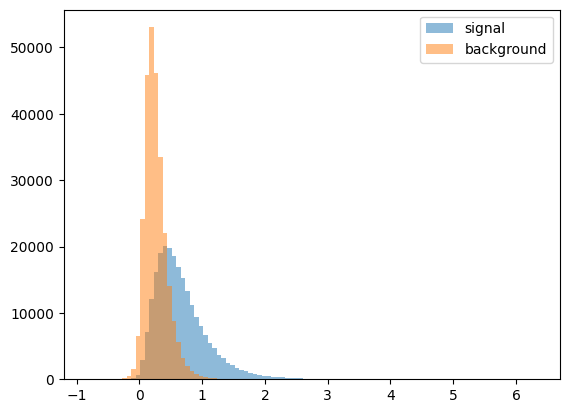

In [60]:
h_s,bins,_=plt.hist(output_s,label="signal",alpha=0.5,bins=100)
h_b,bins,_=plt.hist(output_b,bins=bins,alpha=0.5,label="background")
plt.legend()